## Make necessary imports

In [1]:
import sys
sys.path.insert(0, '../')

In [2]:
import pandas as pd
import numpy as np
np.set_printoptions(precision=3, linewidth=200, suppress=True)
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split as train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import sklearn.metrics as skm
from sklearn import svm
from sklearn.externals import joblib
import os, time
import matplotlib.pyplot as plt
from scipy.misc import toimage
%matplotlib inline

In [3]:
from library.hog.hog import HOG
from library.datasets.cifar10 import CIFAR10
from library.utils import file_utils
from library.plot_tools import plot

In [4]:
total_time = 0

## Experiment

In [5]:
exp_no = 1
file_no = 2
data_source = 'Website'
train_validate_split = 0.2
train_validate_split_data = None
num_images_required = 1.0

In [6]:
one_hot = True
make_image = True
mode='grey'
scale_method = 'StandardScaler'

In [7]:
svm_kernel = 'rbf'
svm_gamma = 0.001
svm_c = 1.0
svm_max_iter = 10000
svm_cs =1000

In [8]:
param_name = 'exp_' + str(exp_no).zfill(3) + '_kernel_' + svm_kernel  
output_directory = '../logs/cifar10/' + str(file_no).zfill(3) + '_svm_hog/' + 'exp_no_' + str(exp_no).zfill(3) + '/'

In [9]:
block_size = (8,8)
cell_size = (2,2)
nbins = 9

## Step 1.1: Load CIFAR 10 Dataset

In [10]:
start = time.time()
cifar10 = CIFAR10(one_hot_encode=one_hot, num_images=num_images_required, make_image=make_image, image_mode=mode,
                  train_validate_split=train_validate_split_data, endian='little')
cifar10.load_data(train=True, test=True, data_directory='./datasets/cifar10/')
end = time.time()
print('[ Step 0] Dataset loaded in %5.6f ms' %((end-start)*1000))
print('Dataset size: ' + str(cifar10.train.data.shape))
num_train_images = cifar10.train.data.shape[0]
total_time += (end-start)

Loading CIFAR 10 Dataset
MD5sum of the file: ./datasets/cifar10/cifar-10.tar.gz is verified
Loading 50000 train images
Loading CIFAR 10 Training Dataset
Reading unpicked data file: ./datasets/cifar10/cifar-10-batches/data_batch_1
Reading unpicked data file: ./datasets/cifar10/cifar-10-batches/data_batch_2
Reading unpicked data file: ./datasets/cifar10/cifar-10-batches/data_batch_3
Reading unpicked data file: ./datasets/cifar10/cifar-10-batches/data_batch_4
Reading unpicked data file: ./datasets/cifar10/cifar-10-batches/data_batch_5
Loading 10000 test images
Loading CIFAR 10 Test Dataset
Unpickling test file: ./datasets/cifar10/cifar-10-batches/test_batch
Reading unpicked test file: ./datasets/cifar10/cifar-10-batches/test_batch
Loaded CIFAR 10 Dataset in 2.1333 seconds
[ Step 0] Dataset loaded in 2134.073734 ms
Dataset size: (50000, 3072)


In [11]:
print('Train data shape:', cifar10.train.data.shape)
if one_hot is True:
    print('Train labels shape:', cifar10.train.one_hot_labels.shape)
if make_image is True:
    print('Train images shape:', cifar10.train.images.shape)
print('Train class labels shape:', cifar10.train.class_labels.shape)
if train_validate_split_data is not None:
    print('Validate data shape:', cifar10.validate.data.shape)
    if one_hot is True:
        print('Validate labels shape:', cifar10.validate.one_hot_labels.shape)
    if make_image is True:
        print('Validate images shape:', cifar10.vaidate.images.shape)
    print('Validate class labels shape:', cifar10.validate.class_labels.shape)
print('Test data shape:', cifar10.test.data.shape)
if one_hot is True:
    print('Test labels shape:', cifar10.test.one_hot_labels.shape)
if make_image is True:
    print('Test images shape:', cifar10.test.images.shape)
print('Test class labels shape:', cifar10.test.class_labels.shape)

Train data shape: (50000, 3072)
Train labels shape: (50000, 10)
Train images shape: (50000, 32, 32)
Train class labels shape: (50000,)
Test data shape: (10000, 3072)
Test labels shape: (10000, 10)
Test images shape: (10000, 32, 32)
Test class labels shape: (10000,)


In [12]:
print('Training images')
print(cifar10.train.data[:5])
if make_image is True and mode=='rgb':
    print('Training images rgb')
    print(cifar10.train.images[:5])
if make_image is True and mode=='float':
    print('Training images float')
    print(cifar10.train.images[:5])
if one_hot is True:
    print('Training labels')
    print(cifar10.train.one_hot_labels[:5])
print('Training classes')
print(cifar10.train.class_labels[:5])
print('Testing images')
print(cifar10.test.data[:5])
if make_image is True and mode=='rgb':
    print('Testing images rgb')
    print(cifar10.test.images[:5])
if make_image is True and mode=='float':
    print('Testing images float')
    print(cifar10.test.images[:5])
if one_hot is True:
    print('Testing labels')
    print(cifar10.test.one_hot_labels[:5])
print('Testing classes')
print(cifar10.test.class_labels[:5])

Training images
[[ 59  43  50 ..., 140  84  72]
 [154 126 105 ..., 139 142 144]
 [255 253 253 ...,  83  83  84]
 [ 28  37  38 ...,  28  37  46]
 [170 168 177 ...,  82  78  80]]
Training labels
[[ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]]
Training classes
[6 9 9 4 1]
Testing images
[[158 159 165 ..., 124 129 110]
 [235 231 232 ..., 178 191 199]
 [158 158 139 ...,   8   3   7]
 [155 167 176 ...,  50  52  50]
 [ 65  70  48 ..., 136 146 117]]
Testing labels
[[ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]]
Testing classes
[3 8 8 0 6]


## Step 1.2: Load CIFAR 10 HOG Train Dataset

In [13]:
start = time.time()
data_hog = []
feature_size = 0
hog = HOG(block_size=block_size, cell_size=cell_size, nbins=nbins)
print('Generating HOG features for %d data images' %cifar10.train.images.shape[0])
for fig_num in range(cifar10.train.images.shape[0]):
    img = cifar10.train.images[fig_num, :]
    gradients = hog.make_hog_gradients(img.astype('uint8'))
    data_hog.append(gradients.flatten())
    feature_size = gradients.size
data_hog = np.array(data_hog)
print('HOG Features for data: ' + str(data_hog.shape))
end = time.time()
print('Generated HOG for train images in %.6f ms' %((end-start)*1000))

Generating HOG features for 50000 data images
HOG Features for data: (50000, 2304)
Generated HOG for train images in 46732.909679 ms


## Step 1.3: Load CIFAR 10 HOG Test Dataset

In [14]:
start = time.time()
test_hog = []
feature_size = 0
print('Generating HOG features for %d test images' %cifar10.test.images.shape[0])
for fig_num in range(cifar10.test.images.shape[0]):
    img = cifar10.test.images[fig_num, :]
    gradients = hog.make_hog_gradients(img.astype('uint8'))
    test_hog.append(gradients.flatten())
    feature_size = gradients.size
test_hog = np.array(test_hog)
print('HOG Features for test: ' + str(test_hog.shape))
end = time.time()
print('Generated HOG for test images in %.6f ms' %((end-start)*1000))

Generating HOG features for 10000 test images
HOG Features for test: (10000, 2304)
Generated HOG for test images in 9214.020014 ms


## Step 1.4 Display an image

Plotting CIFAR 10 Train Dataset


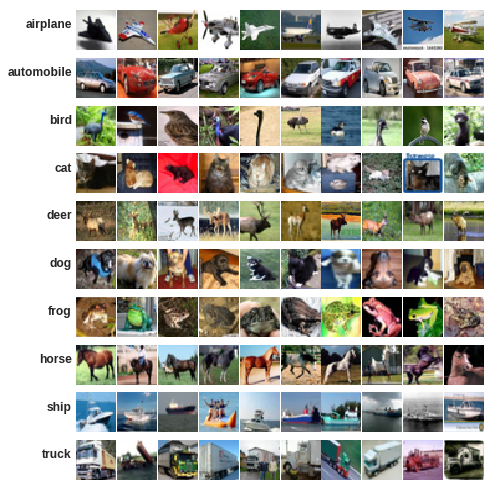

Plotting CIFAR 10 Test Dataset


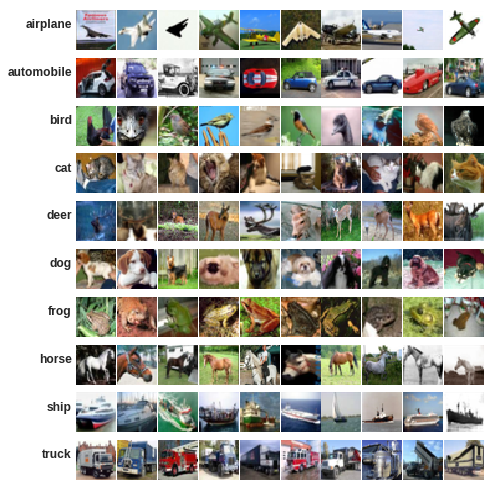

In [15]:
cifar10.plot_sample(plot_data=True, plot_test=True, fig_size=(7, 7))

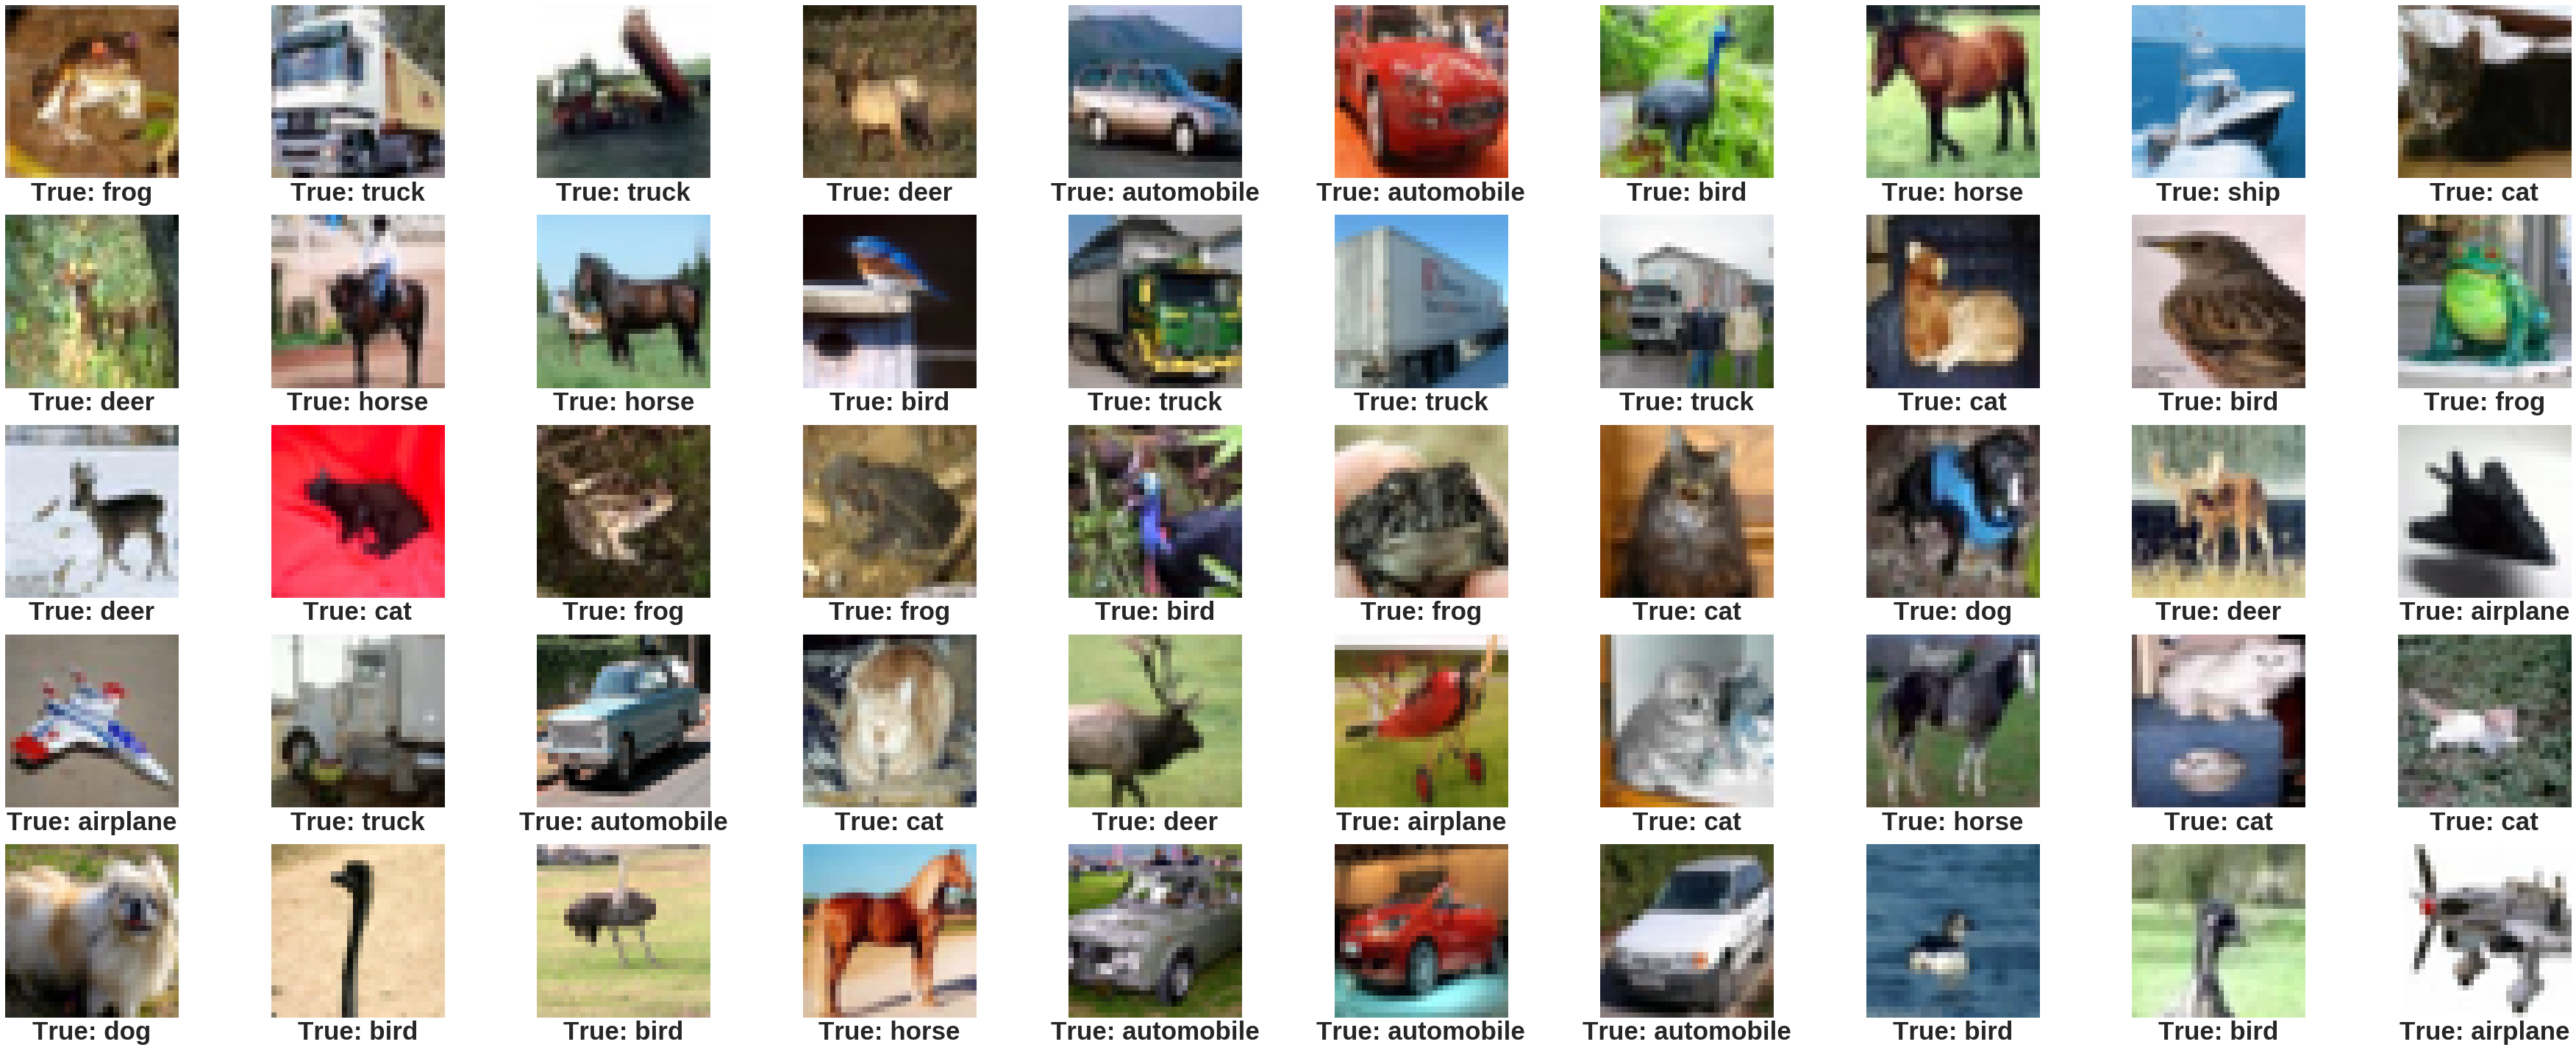

True

In [16]:
cifar10.plot_images(cifar10.train.data[:50, :], cifar10.train.class_names[:50], 
                    nrows=5, ncols=10, fig_size=(20,50), fontsize=35, convert=True)

## Step 2: Preprocess data

In [17]:
start = time.time()
if scale_method == 'StandardScaler':
    ss = StandardScaler()
elif scale_method == 'MinMaxScaler':
    ss = MinMaxScaler()
else:
    ss = StandardScaler()
data_images = ss.fit_transform(data_hog)
test_images = ss.fit_transform(test_hog)
end = time.time()
print('[ Step 2] Dataset transformations done in %.6f ms' %((end-start)*1000))
print('Training the classifier on %d images' % num_train_images)
print('Dataset size: ' + str(cifar10.train.data.shape))
total_time += (end-start)

[ Step 2] Dataset transformations done in 1980.759859 ms
Training the classifier on 50000 images
Dataset size: (50000, 3072)


## Step 3: Train Test Split of data

In [18]:
start = time.time()
X_train, X_test, y_train, y_test = train_test_split(data_images, cifar10.train.class_labels, 
                                                    test_size=train_validate_split)
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)
print('Train set shape         : ' + str(X_train.shape))
print('Train labels shape      : ' + str(y_train.shape))
print('Validation set shape    : ' + str(X_test.shape))
print('Validation labels shape : ' + str(y_test.shape))
end = time.time()
print('[ Step 3] Train-test split done in %.6f ms' %((end-start)*1000))
total_time += (end-start)

Train set shape         : (40000, 2304)
Train labels shape      : (40000,)
Validation set shape    : (10000, 2304)
Validation labels shape : (10000,)
[ Step 3] Train-test split done in 446.336985 ms


## Step 4: Initiate Support Vector Classifier

In [19]:
start = time.time()
clf = svm.SVC(kernel=svm_kernel, C=svm_c, verbose=True, max_iter=svm_max_iter, cache_size=svm_cs, gamma=svm_gamma)
print(clf)
end = time.time()
print('[ Step 4] Made the SVM classifier in %.6f ms' %((end-start)*1000))
total_time += (end-start)

SVC(C=1.0, cache_size=1000, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.001, kernel='rbf',
  max_iter=10000, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=True)
[ Step 4] Made the SVM classifier in 0.610828 ms


## Step 5: Generate the SVC Model using the train data

In [20]:
start = time.time()
print(X_train.shape)
print(y_train.shape)
clf.fit(X_train, y_train)
end = time.time()
print('[ Step 5] Made the model in %.6f ms' %((end-start)*1000))
total_time += (end-start)

(40000, 2304)
(40000,)
[LibSVM][ Step 5] Made the model in 5066023.002863 ms


## Step 6: Write the obtained model to file for further use

In [21]:
start = time.time()
file_utils.mkdir_p(output_directory)
model_output_path = output_directory + '02_' + param_name + '.pkl'
joblib.dump(clf, model_output_path)
end = time.time()
print('[ Step 6] Write obtained model to %s in %.6f ms' %(model_output_path, ((end-start)*1000)))
total_time += (end-start)

[ Step 6] Write obtained model to ../logs/cifar10/002_svm_hog/exp_no_001/02_exp_001_kernel_rbf.pkl in 385.711193 ms


## Step 7: Do the prediction on validation set

Labels: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Confusion matrix, without normalization
[[657  30  85  23  36   4  10  12 119  26]
 [ 32 715  23  20  28   5  13  12  54  63]
 [ 92  19 516  77  79  80  50  22  23   9]
 [ 31  22 140 390  88 183  86  31  22  28]
 [ 50   8  91  94 533  60  62  68  12  31]
 [ 13   9 115 163  79 494  50  71   5  14]
 [ 20  20  79  60  61  45 721  18  13   4]
 [ 22  16  63  72  86  91  14 611   7  33]
 [112  46  36  17  14   4   8  10 652  42]
 [ 31  72  21  41  25   9   9  41  56 721]]
Normalized confusion matrix
[[ 0.656  0.03   0.085  0.023  0.036  0.004  0.01   0.012  0.119  0.026]
 [ 0.033  0.741  0.024  0.021  0.029  0.005  0.013  0.012  0.056  0.065]
 [ 0.095  0.02   0.534  0.08   0.082  0.083  0.052  0.023  0.024  0.009]
 [ 0.03   0.022  0.137  0.382  0.086  0.179  0.084  0.03   0.022  0.027]
 [ 0.05   0.008  0.09   0.093  0.528  0.059  0.061  0.067  0.012  0.031]
 [ 0.013  0.009  0.114  0.161  0.078  0.488  0.049  0.07   0.005  0.014]
 [ 0.019  0.019  0.076  

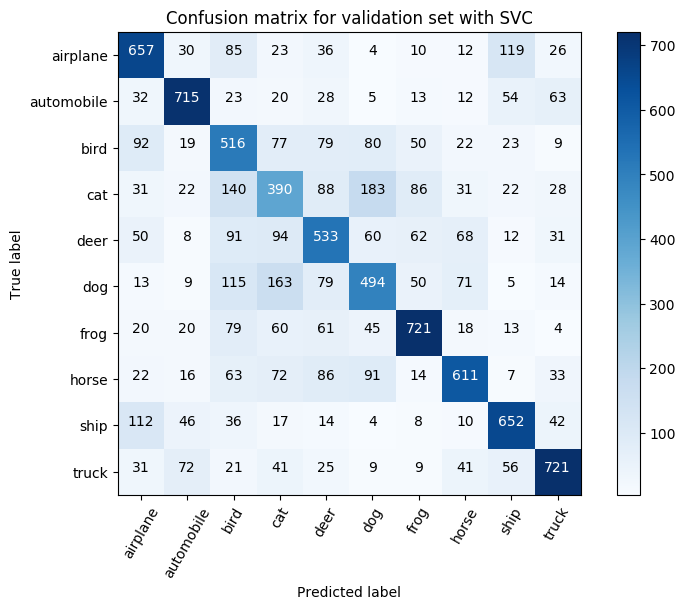

[ Step 7] Make prediction on validation dataset in 952689.131260 ms


In [22]:
y_predict = clf.predict(X_test)
labels = sorted(list(set(cifar10.train.class_labels)))
print('Labels: ' + str(labels))
plot.plot_confusion_matrix(y_test, y_predict, classes=cifar10.classes, fig_size=(8,6),
                           normalize=True, title='Confusion matrix for validation set with SVC')
end = time.time()
print('[ Step 7] Make prediction on validation dataset in %.6f ms' %((end-start)*1000))
total_time += (end-start)

## Step 8: Generate the Classification report

In [23]:
start = time.time()
print('Classification report:')
print(skm.classification_report(y_test, y_predict, target_names=cifar10.classes))
validate_accuracy = skm.accuracy_score(y_test, y_predict, normalize=True)
print('Validation accuracy score: ' + str(validate_accuracy))
end = time.time()
print('[ Step 8] Generating classification on validation dataset in %.6f ms' %((end-start)*1000))
total_time += (end-start)

Classification report:
             precision    recall  f1-score   support

   airplane       0.62      0.66      0.64      1002
 automobile       0.75      0.74      0.74       965
       bird       0.44      0.53      0.48       967
        cat       0.41      0.38      0.39      1021
       deer       0.52      0.53      0.52      1009
        dog       0.51      0.49      0.50      1013
       frog       0.70      0.69      0.70      1041
      horse       0.68      0.60      0.64      1015
       ship       0.68      0.69      0.68       941
      truck       0.74      0.70      0.72      1026

avg / total       0.60      0.60      0.60     10000

Validation accuracy score: 0.601
[ Step 8] Generating classification on validation dataset in 5.641222 ms


## Step 9: Generate the predictions on test data set

In [24]:
start = time.time()
prediction_numbers = clf.predict(test_images)
prediction_classes = []
num_test_images = test_hog.shape[0]
for i in range(num_test_images):
    prediction_classes.append(cifar10.classes[int(prediction_numbers[i])])
end = time.time()
print('[ Step 9] Make prediction on test dataset in %.6f ms' %((end-start)*1000))
total_time += (end-start)

[ Step 9] Make prediction on test dataset in 995171.300173 ms


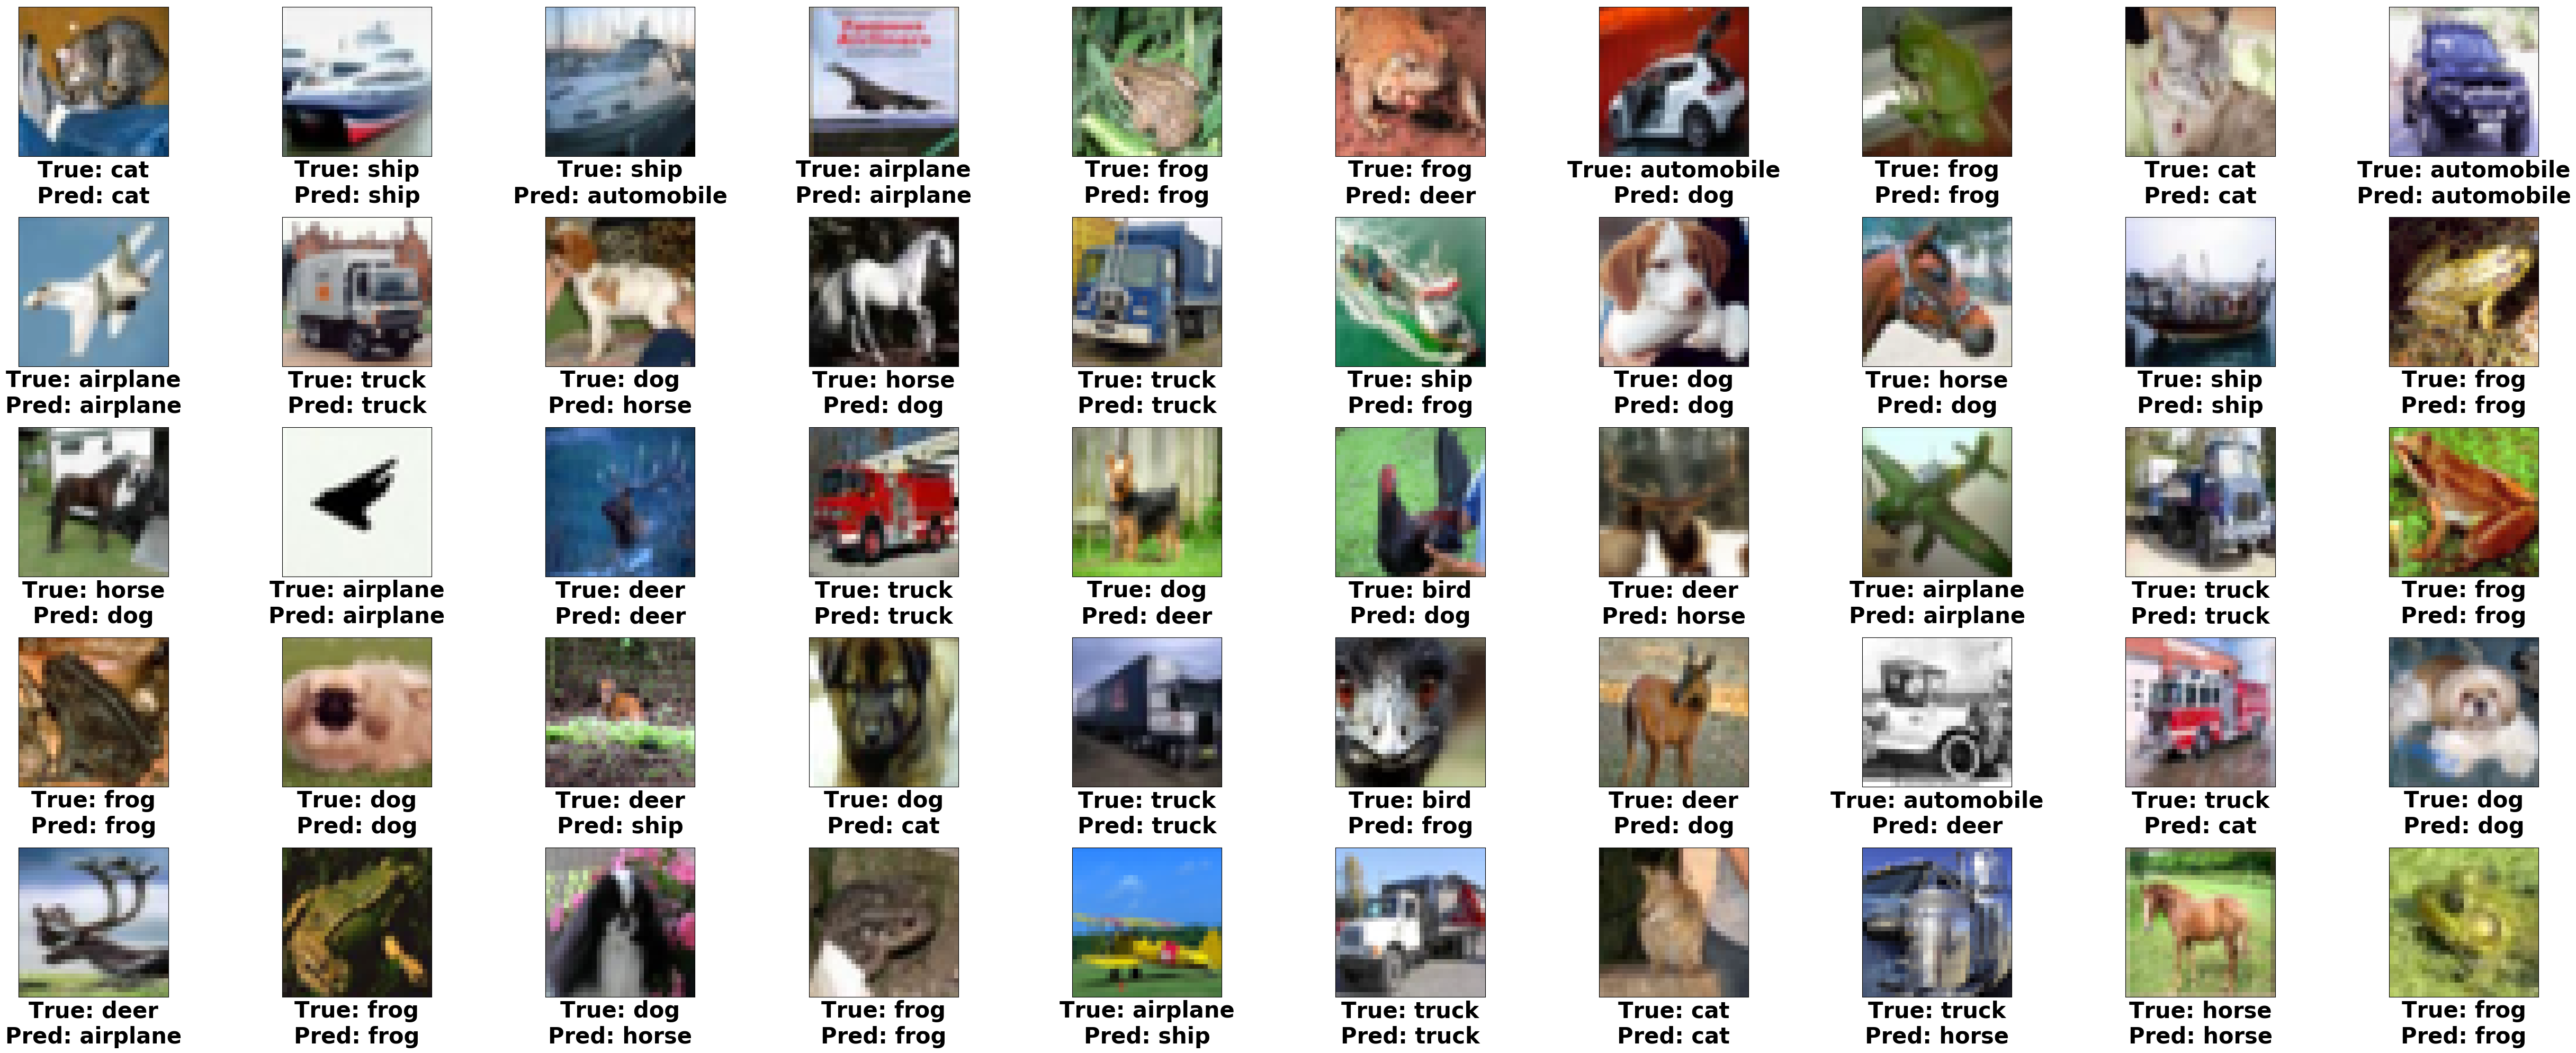

True

In [25]:
cifar10.plot_images(cifar10.test.data[:50], cifar10.test.class_names[:50], cls_pred=prediction_classes[:50], 
                    nrows=5, ncols=10, fig_size=(20,50), fontsize=30, convert=True)

## Step 10: Print the accuracy score of the classifier

Confusion matrix, without normalization
[[662  21  97  18  41   8  10  11 114  18]
 [ 38 718  20  16  16   9  22   8  61  92]
 [ 95  17 472  81  99 103  70  28  21  14]
 [ 46  16 111 390 100 187  57  47  11  35]
 [ 41  20  87  83 515  67  69  74  22  22]
 [ 17  14 111 198  68 458  45  68  10  11]
 [ 29  25  67  56  50  40 696  18  11   8]
 [ 19   8  72  56  86 107  16 590  12  34]
 [ 96  72  28  12  23   7   8  11 689  54]
 [ 35  69  24  34  26  15  11  27  51 708]]
Normalized confusion matrix
[[ 0.662  0.021  0.097  0.018  0.041  0.008  0.01   0.011  0.114  0.018]
 [ 0.038  0.718  0.02   0.016  0.016  0.009  0.022  0.008  0.061  0.092]
 [ 0.095  0.017  0.472  0.081  0.099  0.103  0.07   0.028  0.021  0.014]
 [ 0.046  0.016  0.111  0.39   0.1    0.187  0.057  0.047  0.011  0.035]
 [ 0.041  0.02   0.087  0.083  0.515  0.067  0.069  0.074  0.022  0.022]
 [ 0.017  0.014  0.111  0.198  0.068  0.458  0.045  0.068  0.01   0.011]
 [ 0.029  0.025  0.067  0.056  0.05   0.04   0.696  0.018  0.01

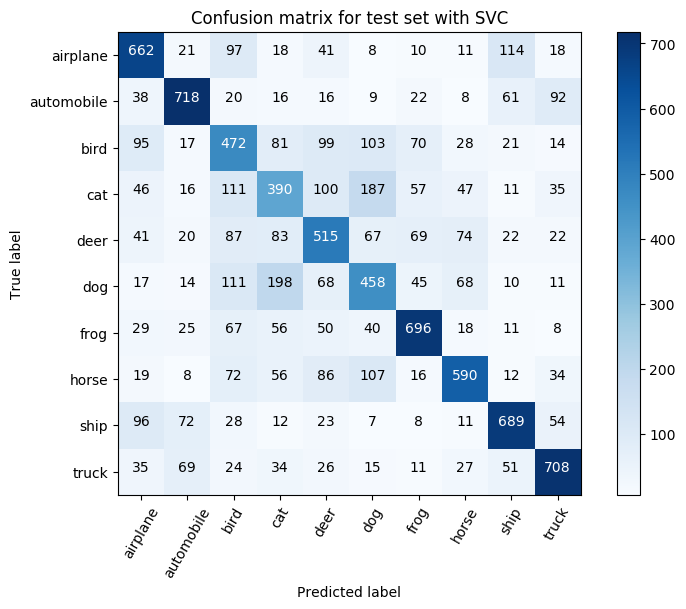

             precision    recall  f1-score   support

   airplane       0.61      0.66      0.64      1000
 automobile       0.73      0.72      0.73      1000
       bird       0.43      0.47      0.45      1000
        cat       0.41      0.39      0.40      1000
       deer       0.50      0.52      0.51      1000
        dog       0.46      0.46      0.46      1000
       frog       0.69      0.70      0.69      1000
      horse       0.67      0.59      0.63      1000
       ship       0.69      0.69      0.69      1000
      truck       0.71      0.71      0.71      1000

avg / total       0.59      0.59      0.59     10000

Accuracy score on test data: 0.5898


In [26]:
start = time.time()
plot.plot_confusion_matrix(cifar10.test.class_labels, prediction_numbers, classes=cifar10.classes,
                           normalize=True, title='Confusion matrix for test set with SVC')
print(skm.classification_report(cifar10.test.class_labels, prediction_numbers, target_names=cifar10.classes))
test_accuracy = skm.accuracy_score(cifar10.test.class_labels, prediction_numbers, normalize=True)
print('Accuracy score on test data: ' + str(test_accuracy))
end = time.time()
total_time += (end-start)

In [27]:
start = time.time()
print('Prediction done on %d images' %test_images.shape[0])
print('Accuracy of the classifier: %.4f' %clf.score(test_images, cifar10.test.class_labels))
end = time.time()

Prediction done on 10000 images
Accuracy of the classifier: 0.5898


## Step 11: Write the predictions to CSV file

In [28]:
start = time.time()
indices = np.arange(1, test_images.shape[0]+1)
predictions = np.column_stack((indices, prediction_classes))
file_utils.mkdir_p(output_directory)
output_csv_file = output_directory + '02_' + param_name + '.csv'
column_names = ['id', 'label']
predict_test_df = pd.DataFrame(data=predictions, columns=column_names)
predict_test_df.to_csv(output_csv_file, index=False)
end = time.time()
print('[ Step 11] Writing the test data to file: %s in %.6f ms' %(output_csv_file, (end-start)*1000))
total_time += (end-start)

[ Step 11] Writing the test data to file: ../logs/cifar10/002_svm_hog/exp_no_001/02_exp_001_kernel_rbf.csv in 43.534517 ms


In [29]:
print('Code took %.6f s to run on training with %d examples' % (total_time,num_train_images))

Code took 7019.570220 s to run on training with 50000 examples


## Print the parameters for record

In [30]:
print('| %d | ' %exp_no, end='')
print('%d | '%num_train_images, end='')
print('Kernel = %s, C = %.2f, Max. Iterations: %d, Cache size = %d, Random State: 1 | ' 
      %(svm_kernel, svm_c, svm_max_iter, svm_cs), end='')
print('[Link](%s) | ' %output_csv_file, end='')
print('%.4f | ' %validate_accuracy, end='')
print('%.4f | ' %test_accuracy, end='')
print('%s | ' %data_source, end='')
print('[Link](%s) |' %model_output_path)

| 1 | 50000 | Kernel = rbf, C = 1.00, Max. Iterations: 10000, Cache size = 1000, Random State: 1 | [Link](../logs/cifar10/002_svm_hog/exp_no_001/02_exp_001_kernel_rbf.csv) | 0.6010 | 0.5898 | Website | [Link](../logs/cifar10/002_svm_hog/exp_no_001/02_exp_001_kernel_rbf.pkl) |


## Step 12: Write the notebook to HTML file

In [31]:
def output_HTML(read_file, output_file):
    from nbconvert import HTMLExporter
    import codecs
    import nbformat
    exporter = HTMLExporter()
    output_notebook = nbformat.read(read_file, as_version=4)
    print()
    output, resources = exporter.from_notebook_node(output_notebook)
    codecs.open(output_file, 'w', encoding='utf-8').write(output)

In [32]:
%%javascript
var notebook = IPython.notebook
notebook.save_notebook()

<IPython.core.display.Javascript object>

In [35]:
%%javascript
var kernel = IPython.notebook.kernel;
var thename = window.document.getElementById("notebook_name").innerHTML;
var command = "theNotebook = " + "'"+thename+"'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [36]:
current_file = './' + theNotebook + '.ipynb'
output_file = output_directory + str(file_no).zfill(3) + '_exp_no_' + str(exp_no) + '_' + theNotebook + '.html'
print('Current file: ' + str(current_file))
print('Output file: ' + str(output_file))
file_utils.mkdir_p(output_directory) 
output_HTML(current_file, output_file)

Current file: ./02_SVM_HOG_Features_CIFAR_10.ipynb
Output file: ../logs/cifar10/002_svm_hog/exp_no_001/002_exp_no_1_02_SVM_HOG_Features_CIFAR_10.html



In [37]:
print('Code took %.6f s to run on training with %d examples' % (total_time,num_train_images))

Code took 7019.570220 s to run on training with 50000 examples
